In [19]:
import pandas as pd
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [20]:
def df_treat(name):
    df = pd.read_csv(name)
    ndf = pd.DataFrame()
    range_mm={
        'V': {'min':df['V'].min()*0.8, 'max': df['V'].max()*1.2},
        'E': {'min':df['E'].min()*0.8, 'max': df['E'].max()*1.2},
        'VF': {'min':df['VF'].min()*0.8, 'max': df['VF'].max()*1.2},
        'VA': {'min':df['VA'].min()*0.8, 'max': df['VA'].max()*1.2},
        'VB': {'min':df['VB'].min()*0.8, 'max': df['VB'].max()*1.2},
        'CFLA': {'min':0, 'max': df['CFLA'].max()*1.2},
        'CALA': {'min':0, 'max': df['CALA'].max()*1.2},
        'CFK': {'min':0, 'max': df['CFK'].max()*1.2},
        'CBK': {'min':0, 'max': df['CBK'].max()*1.2},
        'I': {'min':0, 'max': df['I'].max()*1.2},
    }
    ndf['exp'] = df['exp']; ndf['t'] = df['t']

    for col in ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']:
        if col in range_mm:
            ndf[col] = (df[col] - range_mm[col]['min'])/(range_mm[col]['max'] - range_mm[col]['min'])
        else:
            ndf[col] = df[col]

    exp_num_list = sorted(ndf['exp'].unique())

    return df, ndf, range_mm, exp_num_list

In [21]:
def seq_data(ndf, exp_num_list):
    seq = []
    feature_cols = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
    
    for exp in exp_num_list:
        exp_df = ndf[ndf['exp'] == exp]
        seq.append(exp_df[feature_cols].values)
    
    return seq

In [22]:
def pad_seq(seq):
    max_len = max([len(s) for s in seq])
    seq_len = [len(s) for s in seq]
    pad_seq = pad_sequence([torch.tensor(s) for s in seq], batch_first=True, padding_value=-1)

    return pad_seq, seq_len, max_len

In [23]:
def gen_dataset(pad_seq, seq_len):
    input_tensor = pad_seq.float()
    seq_len_tensor = torch.tensor(seq_len)
    dataset = TensorDataset(input_tensor, seq_len_tensor)
    return dataset

In [24]:
# LSTM with layer normalization
class LayerNormLSTM(nn.Module):
    def __init__(self, input_node, hidden_node):
        super().__init__()
        self.input_node = input_node
        self.hidden_node = hidden_node

        self.w_x = nn.Linear(input_node, 4*hidden_node, bias=False)
        self.w_h = nn.Linear(hidden_node, 4*hidden_node, bias=False)
        self.ln = nn.LayerNorm(4 * hidden_node)
        self.ln_c = nn.LayerNorm(hidden_node)

    def forward(self, x, hx):
        h, c = hx

        gates = self.w_x(x) + self.w_h(h)
        gates = self.ln(gates)

        i, f, g, o = gates.chunk(4, dim=1)

        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)

        c_new = f * c + i * g
        c_new = self.ln_c(c_new)
        h_new = o * torch.tanh(c_new)

        return h_new, c_new

In [25]:
# State feature extractor using LayerNorm LSTM
class StateExtr(nn.Module):
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()
        self.hidden_node = hidden_node
        self.n_layer = n_layer
        self.input_node = input_node

        self.lstm_cells = nn.ModuleList()
        self.lstm_cells.append(LayerNormLSTM(input_node, hidden_node))

        for i in range(n_layer - 1):
            self.lstm_cells.append(LayerNormLSTM(hidden_node, hidden_node))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, seq_len):
        batch_size, max_len, _ = x.size()
        device = x.device

        h_states = []
        c_states = []

        for _ in range(self.n_layer):
            h_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
            c_states.append(torch.zeros(batch_size, self.hidden_node, device=device))

        outputs = []
        for t in range(max_len):
            x_t = x[:, t, :]

            layer_input = x_t # initialize layer input with input tensor
            for layer_idx, lstm_cell in enumerate(self.lstm_cells):
                h_new, c_new = lstm_cell(layer_input, (h_states[layer_idx], c_states[layer_idx]))
                
                h_states[layer_idx] = h_new
                c_states[layer_idx] = c_new

                if layer_idx < len(self.lstm_cells) - 1:
                    layer_input = self.dropout(h_new)
                else:
                    layer_input = h_new

            outputs.append(layer_input)

        output_tensor = torch.stack(outputs, dim=1)
        seq_len_cpu = seq_len.detach().cpu().long()
        mask = torch.arange(max_len, device='cpu')[None, :] < seq_len_cpu[:, None]
        mask = mask.float().to(device).unsqueeze(-1)

        masked_output = output_tensor * mask
        return self.dropout(masked_output)

In [26]:
# Physical change regressor
class PhysRegr(nn.Module):
    def __init__(self, input_node, output_node, n_layer, hidden_node, dropout):
        super().__init__()

        layers = []

        layers.extend([
            nn.Linear(input_node, hidden_node),
            nn.ReLU(),
            nn.Dropout(dropout)
        ])

        for _ in range(n_layer - 1):
            layers.extend([
                nn.Linear(hidden_node, hidden_node),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
        
        layers.append(nn.Linear(hidden_node, output_node))
        layers.append(nn.Sigmoid())

        self.layers = nn.Sequential(*layers)

    def forward(self, hidden_states):
        return self.layers(hidden_states)

In [27]:
# Current regressor
class CurrRegr(nn.Module):
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()

        layers = []

        layers.extend([
            nn.Linear(input_node, hidden_node),
            nn.ReLU(),
            nn.Dropout(dropout)
        ])

        for _ in range(n_layer - 1):
            layers.extend([
                nn.Linear(hidden_node, hidden_node),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
        
        layers.append(nn.Linear(hidden_node, 1))

        self.layers = nn.Sequential(*layers)

    def forward(self, hidden_states):
        return self.layers(hidden_states)   

In [28]:
class PhysConstr(nn.Module):
    def __init__(self, range_mm, curr_regr, eps=1e-2):
        super().__init__()
        self.eps = eps
        self.curr_regr = curr_regr
        self.register_buffer('range_mm_tensor', self._range2tensor(range_mm))

    def _range2tensor(self, range_mm):
        feature_names = ['V','E','VF','VA','VB','CFLA','CALA','CFK','CBK','I']
        ranges = torch.zeros(len(feature_names),2)

        for i, name in enumerate(feature_names):
            if name in range_mm:
                ranges[i, 0] = range_mm[name]['min']
                ranges[i, 1] = range_mm[name]['max']
        
        return ranges
    
    def _norm_tensor(self, data, feature_idx):
        min_val = self.range_mm_tensor[feature_idx, 0]
        max_val = self.range_mm_tensor[feature_idx, 1]
        return (data - min_val) / (max_val - min_val)

    def _denorm_tensor(self, norm_data, feature_idx):
        min_val = self.range_mm_tensor[feature_idx, 0]
        max_val = self.range_mm_tensor[feature_idx, 1]
        return norm_data * (max_val - min_val) + min_val

    def forward(self, phys_chng, cur_state):
        V_idx, E_idx, VF_idx, VA_idx, VB_idx = 0, 1, 2, 3, 4
        CFLA_idx, CALA_idx, CFK_idx, CBK_idx, I_idx = 5, 6, 7, 8, 9

        VF = self._denorm_tensor(cur_state[..., 2:3], VF_idx)
        VA = self._denorm_tensor(cur_state[..., 3:4], VA_idx)
        VB = self._denorm_tensor(cur_state[..., 4:5], VB_idx)
        CFLA = self._denorm_tensor(cur_state[..., 5:6], CFLA_idx)
        CALA = self._denorm_tensor(cur_state[..., 6:7], CALA_idx)
        CFK = self._denorm_tensor(cur_state[..., 7:8], CFK_idx)
        CBK = self._denorm_tensor(cur_state[..., 8:9], CBK_idx)

        NFLA = CFLA * VF
        NALA = CALA * VA
        NFK = CFK * VF
        NBK = CBK * VB

        rdVA = phys_chng[..., 0:1]
        rdVB = phys_chng[..., 1:2]
        rdNALA = phys_chng[..., 2:3]
        rdNBK = phys_chng[..., 3:4]

        dVA = VF*(rdVA -0.5)
        dVB = VF*(rdVB - 0.5)
        dNBK = NFK*rdNBK
        dNALA = NFLA*rdNALA

        nVF = VF - dVA - dVB
        nVA = VA + dVA
        nVB = VB + dVB
        
        nNFLA = NFLA - dNALA
        nNALA = NALA + dNALA
        nNFK = NFK - dNBK
        nNBK = NBK + dNBK

        nCFLA = nNFLA / nVF
        nCALA = nNALA / nVA
        nCFK = nNFK / nVF
        nCBK = nNBK / nVB

        V = cur_state[..., 0:1]
        E = cur_state[..., 1:2]
        nVF_norm = self._norm_tensor(nVF, VF_idx)
        nVA_norm = self._norm_tensor(nVA, VA_idx)
        nVB_norm = self._norm_tensor(nVB, VB_idx)
        nCFLA_norm = self._norm_tensor(nCFLA, CFLA_idx)
        nCALA_norm = self._norm_tensor(nCALA, CALA_idx)
        nCFK_norm = self._norm_tensor(nCFK, CFK_idx)
        nCBK_norm = self._norm_tensor(nCBK, CBK_idx)

        # Create temporary state without I for current prediction
        temp_state = torch.cat([
            V, E, nVF_norm, nVA_norm, nVB_norm, nCFLA_norm, nCALA_norm, nCFK_norm, nCBK_norm
        ], dim=-1)
        
        # Predict new I using the current predictor
        nI_pred = self.curr_regr(temp_state)
        nI_real = self._denorm_tensor(nI_pred, I_idx)
        nI_real = torch.clamp(nI_real, min=0.0)
        nI_norm = self._norm_tensor(nI_real, I_idx)

        # Create final next state with predicted I
        next_state = torch.cat([
            V, E, nVF_norm, nVA_norm, nVB_norm, nCFLA_norm, nCALA_norm, nCFK_norm, nCBK_norm, nI_norm
        ], dim=-1)
        
        return next_state

In [29]:
class BMEDAutoregressiveModel(nn.Module):
    def __init__(self, state_extr_params, phys_regr_params, curr_regr_params, range_mm):
        super().__init__()
        self.state_extr = StateExtr(**state_extr_params)
        self.phys_regr = PhysRegr(**phys_regr_params)
        self.curr_regr = CurrRegr(**curr_regr_params)
        self.phys_constr = PhysConstr(range_mm, self.curr_regr)

    def forward(self, x, seq_len):
        hidden_states = self.state_extr(x, seq_len)
        phys_chng = self.phys_regr(hidden_states)
        new_x = self.phys_constr(phys_chng, x)
        
        return new_x

In [30]:
def masked_mse_loss(pred, target, seq_len):
    _, max_len, _ = pred.shape
    seq_len_cpu = seq_len.detach().cpu().long()

    mask = torch.arange(max_len, device='cpu')[None, :] < seq_len_cpu[:, None]
    mask = mask.float().to(pred.device)

    loss = F.mse_loss(pred, target, reduction='none')
    masked_loss = loss * mask.unsqueeze(-1)

    total_loss = masked_loss.sum()
    total_elements = mask.sum()

    masked_loss = total_loss / total_elements
    return masked_loss

In [31]:
def tf_data(input_seq, seq_len):
    inputs = input_seq[:, :-1, :-1]
    targets = input_seq[:, 1:, :]

    target_seq_len = seq_len - 1

    return inputs, targets, target_seq_len

In [32]:
class NoamScheduler:
    def __init__(self, optimizer, model_size, warmup_epochs, factor=1.0):
        self.optimizer = optimizer
        self.model_size = model_size
        self.warmup_epochs = warmup_epochs
        self.factor = factor
        self.epoch_num = 0

    def step_epoch(self):
        self.epoch_num += 1
        lr = self.factor * (
            self.model_size ** (-0.5) *
            min(self.epoch_num ** (-0.5), self.epoch_num * self.warmup_epochs ** (-1.5))
        )
    
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

        return lr

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
df, ndf, range_mm, exp_num_list = df_treat('BMED_DATA_AG.csv')
seq = seq_data(ndf, exp_num_list)
pad, seq_len, max_len = pad_seq(seq)
dataset = gen_dataset(pad, seq_len)
dataloader = DataLoader(dataset, batch_size=3, shuffle=False)

In [34]:
state_extr_params = {
    'input_node': 9,
    'hidden_node': 96,
    'n_layer': 4,
    'dropout': 0.2
}

phys_regr_params = {
    'input_node': state_extr_params['hidden_node'],
    'hidden_node': 32,
    'n_layer': 3,
    'dropout': 0.1,
    'output_node': 4
}

curr_regr_params = {
    'input_node': 9,
    'hidden_node': 96,
    'n_layer': 3,
    'dropout': 0.1
}

model = BMEDAutoregressiveModel(state_extr_params, phys_regr_params, curr_regr_params, range_mm)
model = model.to(device)
print(f"Model architecture:")
print(f"  Input features: {state_extr_params['input_node']} (without current)")
print(f"  State Extractor Hidden size: {state_extr_params['hidden_node']}")
print(f"  State Extractor layers: {state_extr_params['n_layer']}")
print(f"  Phys Regressor layers: {phys_regr_params['n_layer']}")
print(f"  Phys Regressor Hidden size: {phys_regr_params['hidden_node']}")
print(f"  Current Predictor layers: {curr_regr_params['n_layer']}")
print(f"  Current Predictor Hidden size: {curr_regr_params['hidden_node']}")
print(f"  Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Physics constraints: Volume conservation with denormalization")

num_epochs = 2000
optimizer = torch.optim.AdamW(model.parameters(), lr=1.0)
warmup_epochs = int(num_epochs * 0.1)
scheduler = NoamScheduler(optimizer, model_size=state_extr_params['hidden_node'], warmup_epochs=warmup_epochs, factor=1)

print(f"\nTraining configuration:")
print(f"  Total epochs: {num_epochs:,}")
print(f"  Warmup epochs: {warmup_epochs:,} (10%)")
peak_lr = 1 * (48 ** (-0.5)) * (warmup_epochs ** (-0.5))
print(f"  Peak learning rate: {peak_lr:.2e}")

Model architecture:
  Input features: 9 (without current)
  State Extractor Hidden size: 96
  State Extractor layers: 4
  Phys Regressor layers: 3
  Phys Regressor Hidden size: 32
  Current Predictor layers: 3
  Current Predictor Hidden size: 96
  Model parameters: 290,373
  Physics constraints: Volume conservation with denormalization

Training configuration:
  Total epochs: 2,000
  Warmup epochs: 200 (10%)
  Peak learning rate: 1.02e-02


In [35]:
train_samples = len(dataloader.dataset)
best_train_loss = float('inf')
best_epoch = 0
train_losses = []
learning_rates = []

best_model = None

print("Training started...")
print(f"Total batches per epoch: {len(dataloader)}")

for epoch in range(num_epochs):
    current_lr = scheduler.step_epoch()

    model.train()
    train_loss = 0.0
    train_batches = 0

    for batch_idx, (input_seq, seq_len) in enumerate(dataloader):
        try:
            input_seq = input_seq.to(device)
            seq_len = seq_len.to(device)

            inputs, targets, target_seq_len = tf_data(input_seq, seq_len)
            
            optimizer.zero_grad()
            pred = model(inputs, target_seq_len)
            loss = masked_mse_loss(pred, targets, target_seq_len)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            train_batches += 1

        except Exception as e:
            print(f"Training batch {batch_idx} error: {str(e)}")
            print(f"Input shape: {input_seq.shape if 'input_seq' in locals() else 'N/A'}")
            print(f"Seq lengths: {seq_len if 'seq_lengths' in locals() else 'N/A'}")
            import traceback
            traceback.print_exc()
            continue
    
    if train_batches == 0:
        print("No valid training batches")
        break

    train_losses.append(train_loss)
    learning_rates.append(current_lr)

    if train_loss < best_train_loss:
        best_train_loss = train_loss
        best_epoch = epoch + 1
        best_status = " ‚òÖ NEW BEST"
        
        # Best modelÏùÑ Î©îÎ™®Î¶¨Ïóê Î≥µÏÇ¨ÌïòÏó¨ Ï†ÄÏû•
        import copy
        best_model = copy.deepcopy(model)
        print(f"          Best model saved in memory at epoch {best_epoch}")
        
        # Ïò§Îäò ÎÇ†ÏßúÎ°ú Î™®Îç∏ ÌååÏùº Ï†ÄÏû•
        from datetime import datetime
        today = datetime.now().strftime("%y%m%d")
        model_filename = f"BMED_TF_{today}.pth"
        torch.save({
            'model_state_dict': best_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': best_epoch,
            'best_train_loss': best_train_loss,
            'model_config': {
                'state_extr_params': state_extr_params,
                'phys_regr_params': phys_regr_params,
                'curr_regr_params': curr_regr_params,
                'range_mm': range_mm
            }
        }, model_filename)
        print(f"          Best model saved to {model_filename}")
    else:
        best_status = ""

    # Warmup Íµ¨Í∞Ñ ÌëúÏãú
    if epoch + 1 <= warmup_epochs:
        warmup_status = " [WARMUP]"
    else:
        warmup_status = ""

    # Îß§ ÏóêÌè¨ÌÅ¨ÎßàÎã§ Î°úÍπÖ - best ÏÑ±Îä• Ï†ïÎ≥¥ Ìè¨Ìï®
    print(f"Epoch {epoch+1:4d}: Train: {train_loss:.6f}, LR: {current_lr:.2e}{best_status}{warmup_status}")    

    if epoch == 0:
        print(f"          Best: Train: {best_train_loss:.6f}, (Epoch {best_epoch})")
    elif train_loss < best_train_loss:
        print(f"          ‚úì Updated Best: Train: {best_train_loss:.6f}")
    else:
        print(f"          Best: Train: {best_train_loss:.6f} (Epoch {best_epoch})")

print(f"\nTraining completed!")
print(f"=" * 60)

# ÏïàÏ†ÑÌïú Í≤∞Í≥º Ï∂úÎ†•
if len(train_losses) > 0:
    print(f"Best Performance (Epoch {best_epoch}):")
    print(f"  Best Train Loss:  {best_train_loss:.6f}")
    print(f"=" * 60)
    print(f"Final Performance (Epoch {len(train_losses)}):")
    print(f"  Final Train Loss: {train_losses[-1]:.6f}")
    print(f"  Final LR:         {current_lr:.2e}")
    print(f"=" * 60)
    if len(learning_rates) > 0:
        print(f"Warmup completed at epoch {warmup_epochs} with peak LR: {max(learning_rates):.2e}")
else:
    print("‚ö†Ô∏è No training completed - check error messages above")

# Best modelÏù¥ Ï†ÄÏû•ÎêòÏóàÎäîÏßÄ ÌôïÏù∏
if best_model is not None:
    print(f"\n‚úÖ Best model (Epoch {best_epoch}) successfully saved in memory!")
    print(f"   Best model loss: {best_train_loss:.6f}")
    from datetime import datetime
    today = datetime.now().strftime("%y%m%d")
    model_filename = f"BMED_TF_{today}.pth"
    print(f"   Best model also saved to file: {model_filename}")
else:
    print("\n‚ö†Ô∏è No best model was saved (training may have failed)")
    best_model = model  # fallback to current model

Training started...
Total batches per epoch: 5
          Best model saved in memory at epoch 1
          Best model saved to BMED_TF_251010.pth
Epoch    1: Train: 2.331818, LR: 3.61e-05 ‚òÖ NEW BEST [WARMUP]
          Best: Train: 2.331818, (Epoch 1)
          Best model saved in memory at epoch 2
          Best model saved to BMED_TF_251010.pth
Epoch    2: Train: 2.318287, LR: 7.22e-05 ‚òÖ NEW BEST [WARMUP]
          Best: Train: 2.318287 (Epoch 2)
          Best model saved in memory at epoch 3
          Best model saved to BMED_TF_251010.pth
Epoch    3: Train: 2.303853, LR: 1.08e-04 ‚òÖ NEW BEST [WARMUP]
          Best: Train: 2.303853 (Epoch 3)
          Best model saved in memory at epoch 4
          Best model saved to BMED_TF_251010.pth
Epoch    4: Train: 2.283895, LR: 1.44e-04 ‚òÖ NEW BEST [WARMUP]
          Best: Train: 2.283895 (Epoch 4)
          Best model saved in memory at epoch 5
          Best model saved to BMED_TF_251010.pth
Epoch    5: Train: 2.248638, LR: 1.80e-04 ‚

üöÄ Ï†ÑÏ≤¥ Ïã§Ìóò Îç∞Ïù¥ÌÑ∞ comprehensive evaluation ÏãúÏûë...
üìã Ï†ÑÏ≤¥ 15Í∞ú Ïã§Ìóò Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Ï§ë...
üîß Îç∞Ïù¥ÌÑ∞Î°úÎçî Î∞∞Ïπò ÌÅ¨Í∏∞: 3
üîß Ï¥ù Î∞∞Ïπò Í∞úÏàò: 5
üì¶ Î∞∞Ïπò 0: 3Í∞ú Ïã§Ìóò Ï≤òÎ¶¨ Ï§ë...
‚úÖ Ïã§Ìóò 0: 4.2h, 20.0V, 0.250M
‚úÖ Ïã§Ìóò 1: 5.2h, 30.0V, 0.250M
‚úÖ Ïã§Ìóò 2: 5.2h, 30.0V, 0.250M
üì¶ Î∞∞Ïπò 1: 3Í∞ú Ïã§Ìóò Ï≤òÎ¶¨ Ï§ë...
‚úÖ Ïã§Ìóò 3: 5.2h, 30.0V, 0.250M
‚úÖ Ïã§Ìóò 4: 7.2h, 20.0V, 0.250M
‚úÖ Ïã§Ìóò 5: 9.2h, 20.0V, 0.250M
üì¶ Î∞∞Ïπò 2: 3Í∞ú Ïã§Ìóò Ï≤òÎ¶¨ Ï§ë...
‚úÖ Ïã§Ìóò 6: 4.2h, 10.0V, 0.250M
‚úÖ Ïã§Ìóò 7: 7.2h, 10.0V, 0.250M
‚úÖ Ïã§Ìóò 8: 8.2h, 30.0V, 0.250M
üì¶ Î∞∞Ïπò 3: 3Í∞ú Ïã§Ìóò Ï≤òÎ¶¨ Ï§ë...
‚úÖ Ïã§Ìóò 9: 5.2h, 30.0V, 0.250M
‚úÖ Ïã§Ìóò 10: 6.2h, 30.0V, 0.250M
‚úÖ Ïã§Ìóò 11: 6.2h, 35.0V, 0.500M
üì¶ Î∞∞Ïπò 4: 3Í∞ú Ïã§Ìóò Ï≤òÎ¶¨ Ï§ë...
‚úÖ Ïã§Ìóò 12: 5.2h, 35.0V, 0.250M
‚úÖ Ïã§Ìóò 13: 5.2h, 35.0V, 1.000M
‚úÖ Ïã§Ìóò 14: 4.8h, 30.0V, 0.250M
üìä Ï¥ù 15Í∞ú Ïã§Ìóò Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å!
üìê Í∞Å featureÎãπ 4x4 ÏÑúÎ∏åÌîåÎ°Ø Í∑∏Î¶¨Îìú ÏÇ¨Ïö©
ü

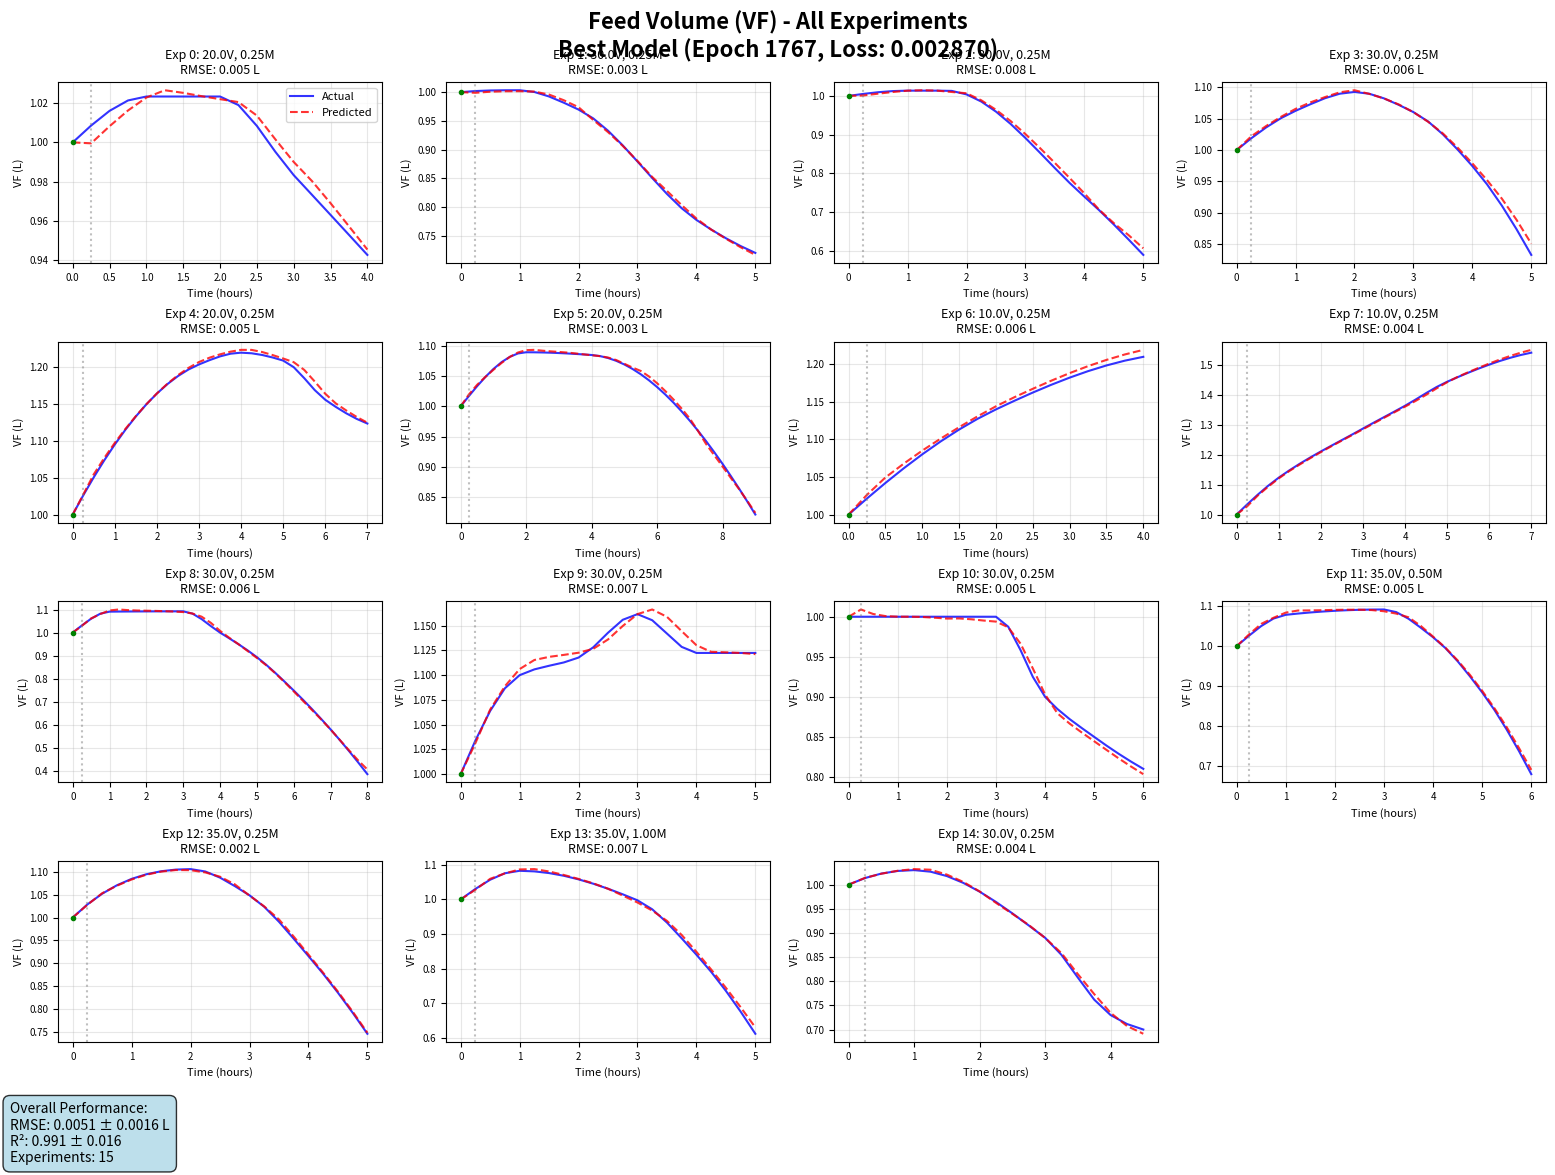

‚úÖ VF ÏôÑÎ£å: ÌèâÍ∑† RMSE = 0.0051 L, ÌèâÍ∑† R¬≤ = 0.991
üé® Feature 2/8: VA (Acid Volume) ÏÉùÏÑ± Ï§ë...


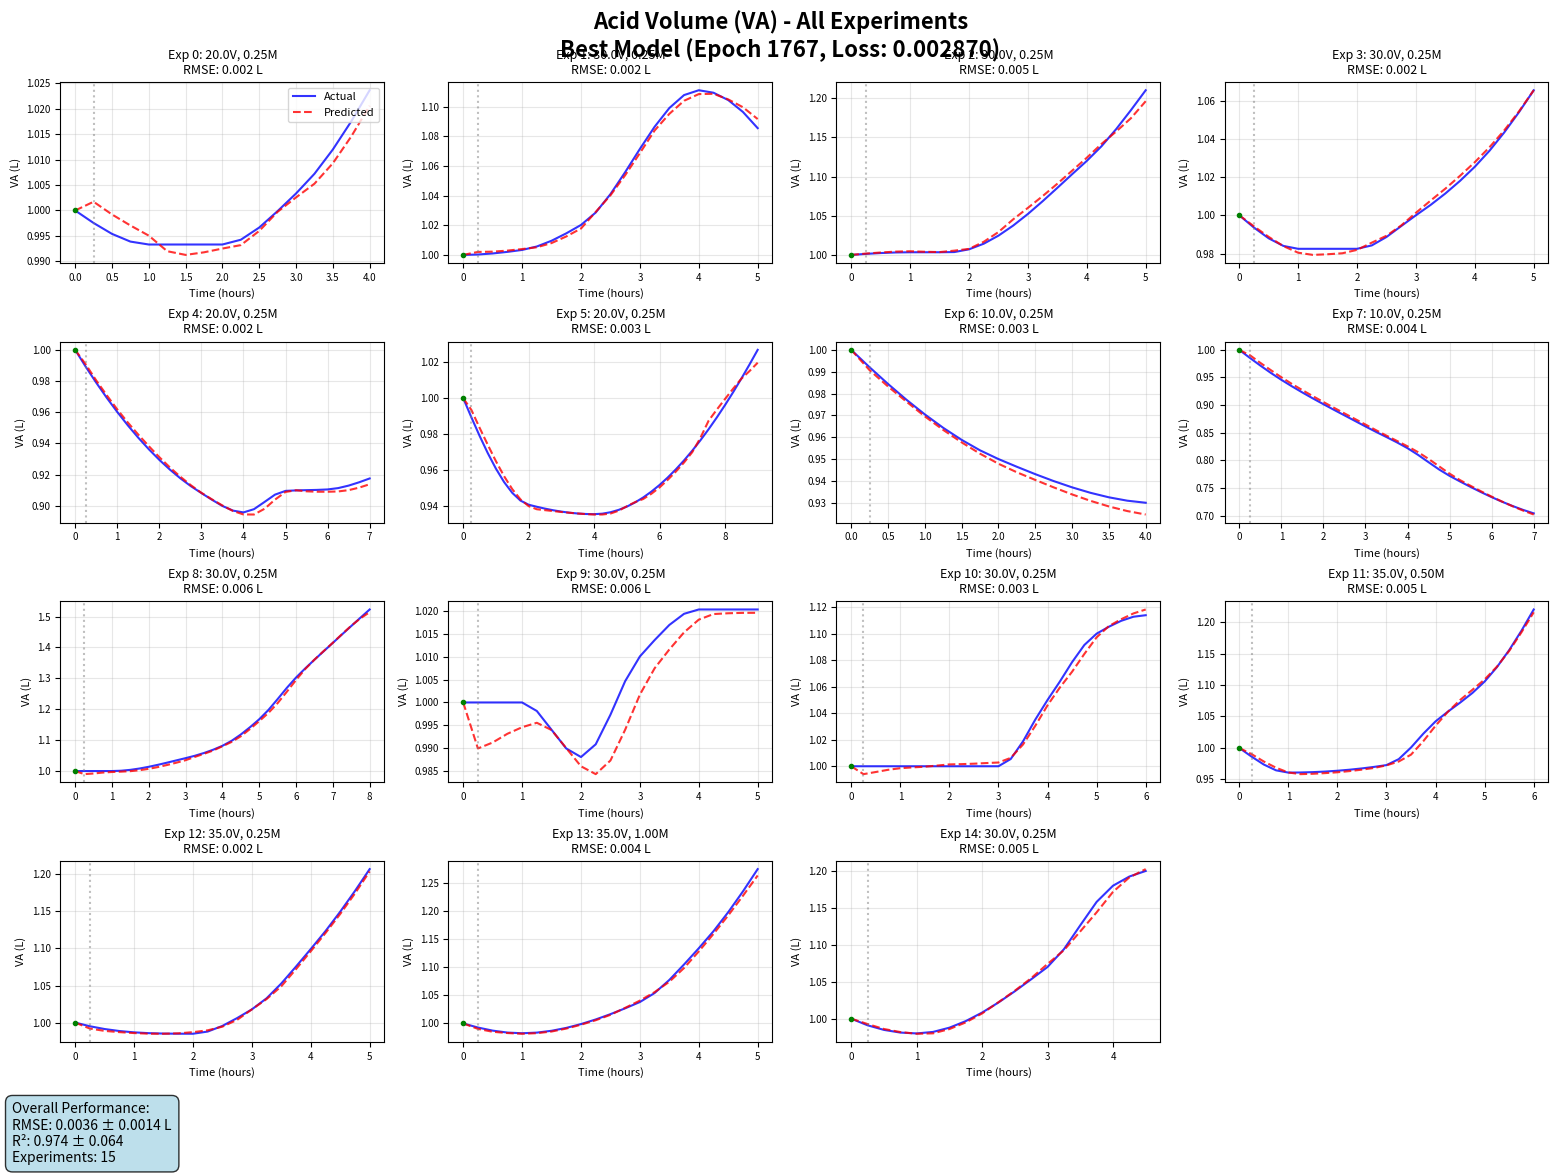

‚úÖ VA ÏôÑÎ£å: ÌèâÍ∑† RMSE = 0.0036 L, ÌèâÍ∑† R¬≤ = 0.974
üé® Feature 3/8: VB (Base Volume) ÏÉùÏÑ± Ï§ë...


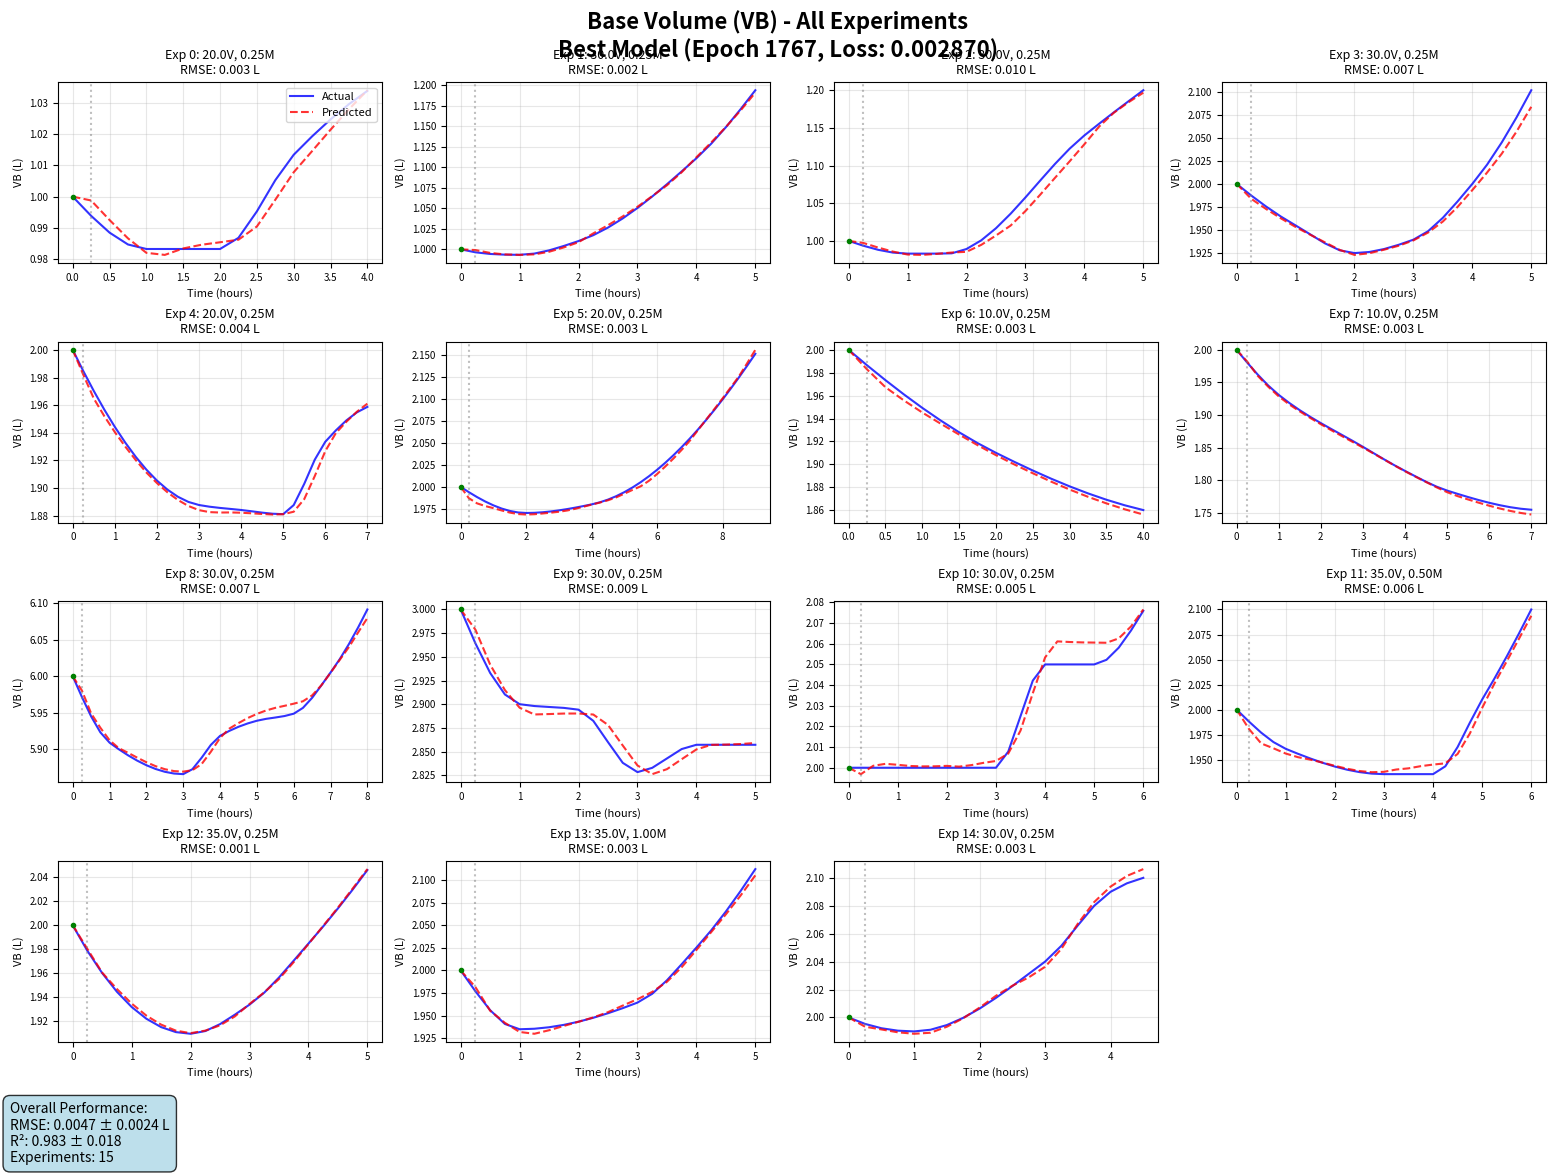

‚úÖ VB ÏôÑÎ£å: ÌèâÍ∑† RMSE = 0.0047 L, ÌèâÍ∑† R¬≤ = 0.983
üé® Feature 4/8: CFLA (Feed LA Conc.) ÏÉùÏÑ± Ï§ë...


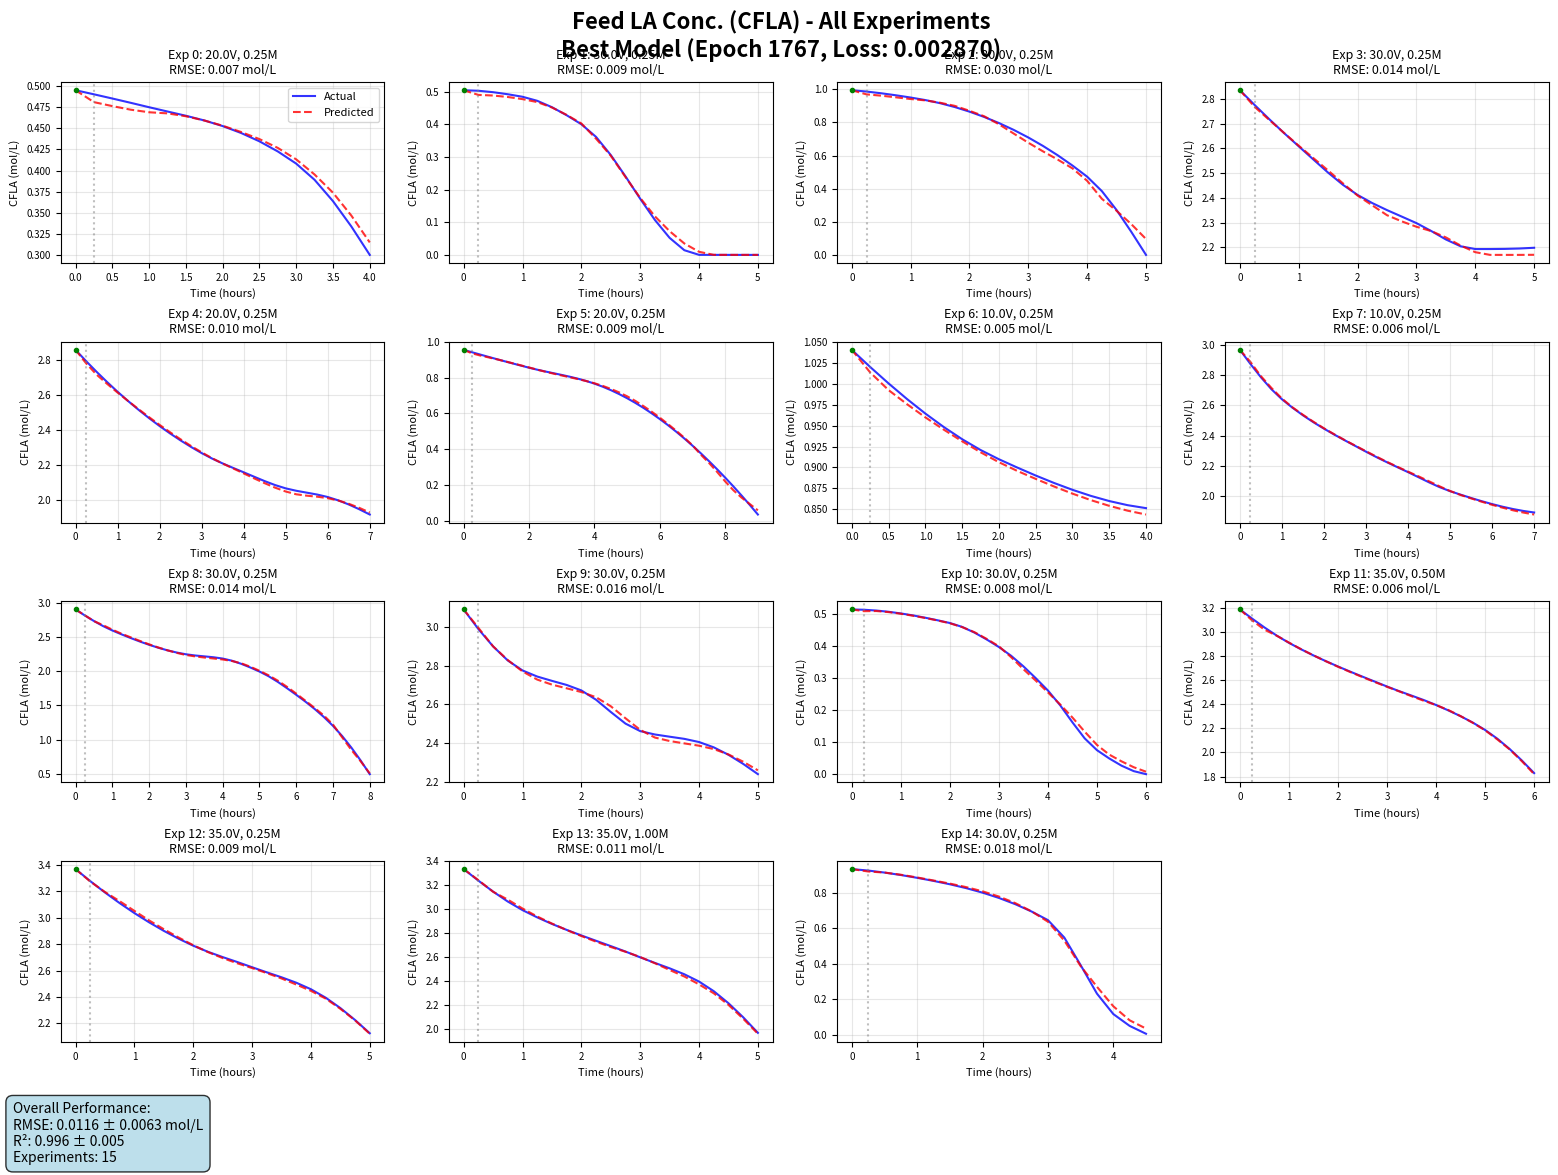

‚úÖ CFLA ÏôÑÎ£å: ÌèâÍ∑† RMSE = 0.0116 mol/L, ÌèâÍ∑† R¬≤ = 0.996
üé® Feature 5/8: CALA (Acid LA Conc.) ÏÉùÏÑ± Ï§ë...


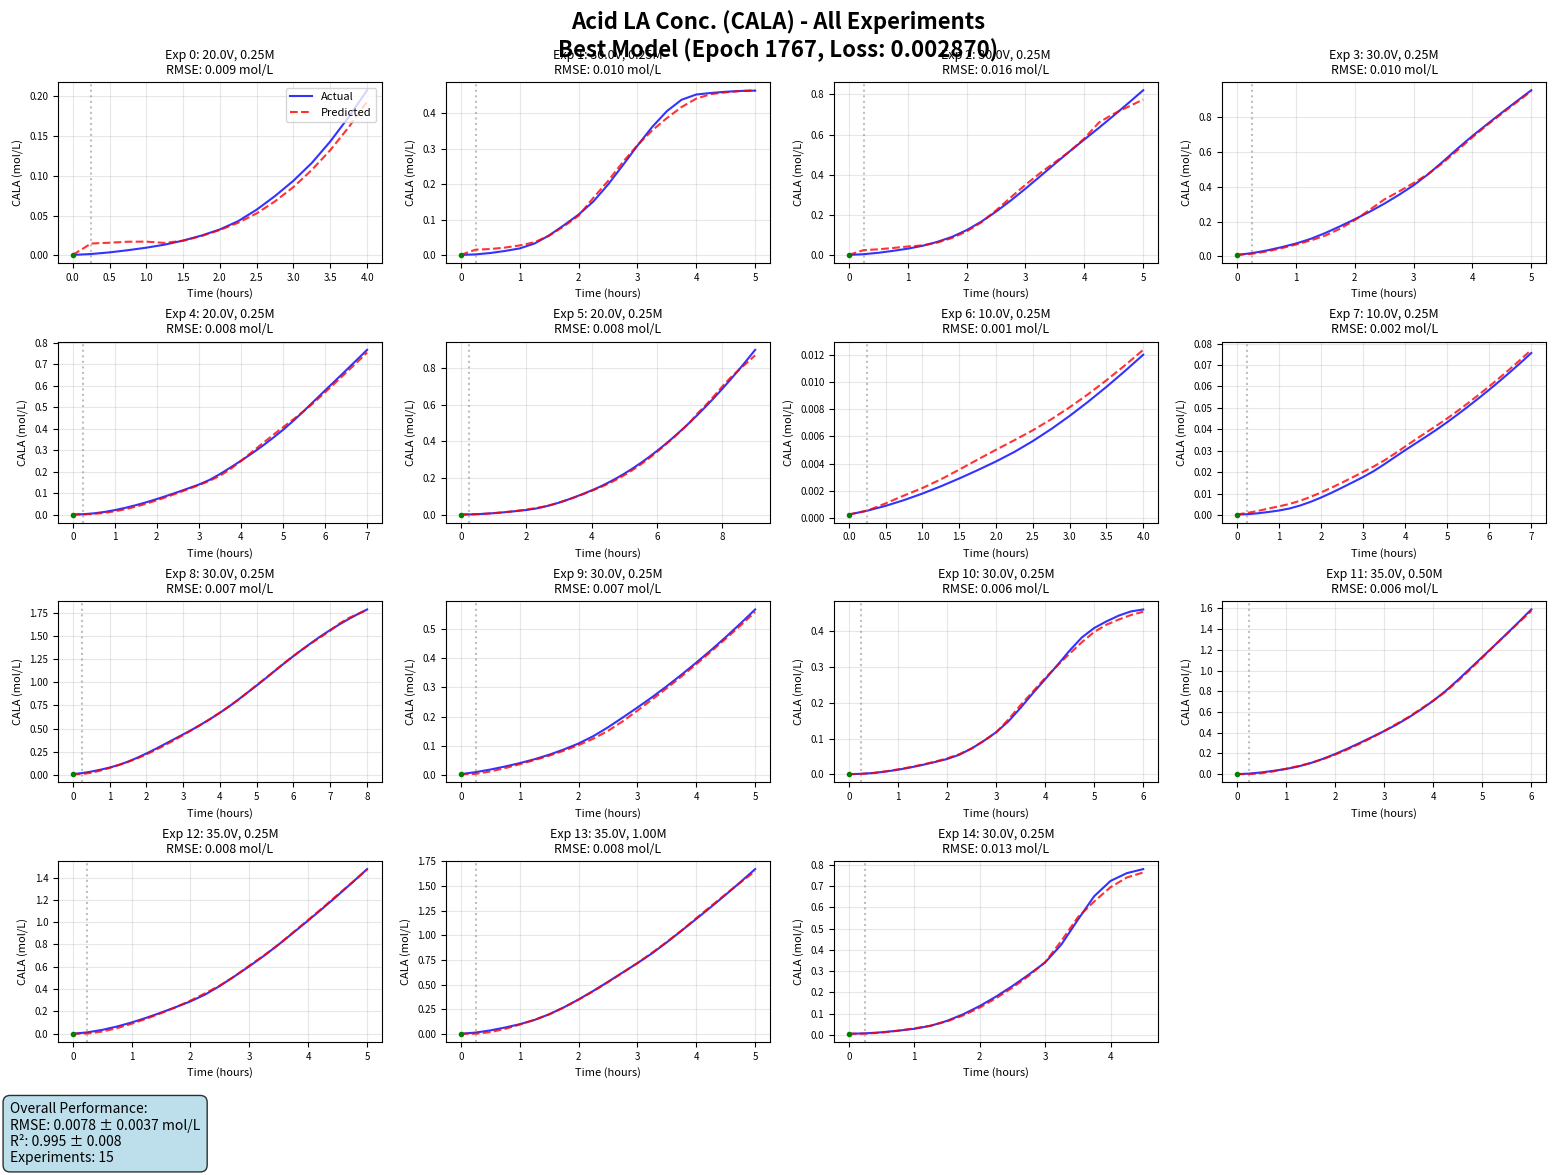

‚úÖ CALA ÏôÑÎ£å: ÌèâÍ∑† RMSE = 0.0078 mol/L, ÌèâÍ∑† R¬≤ = 0.995
üé® Feature 6/8: CFK (Feed K Conc.) ÏÉùÏÑ± Ï§ë...


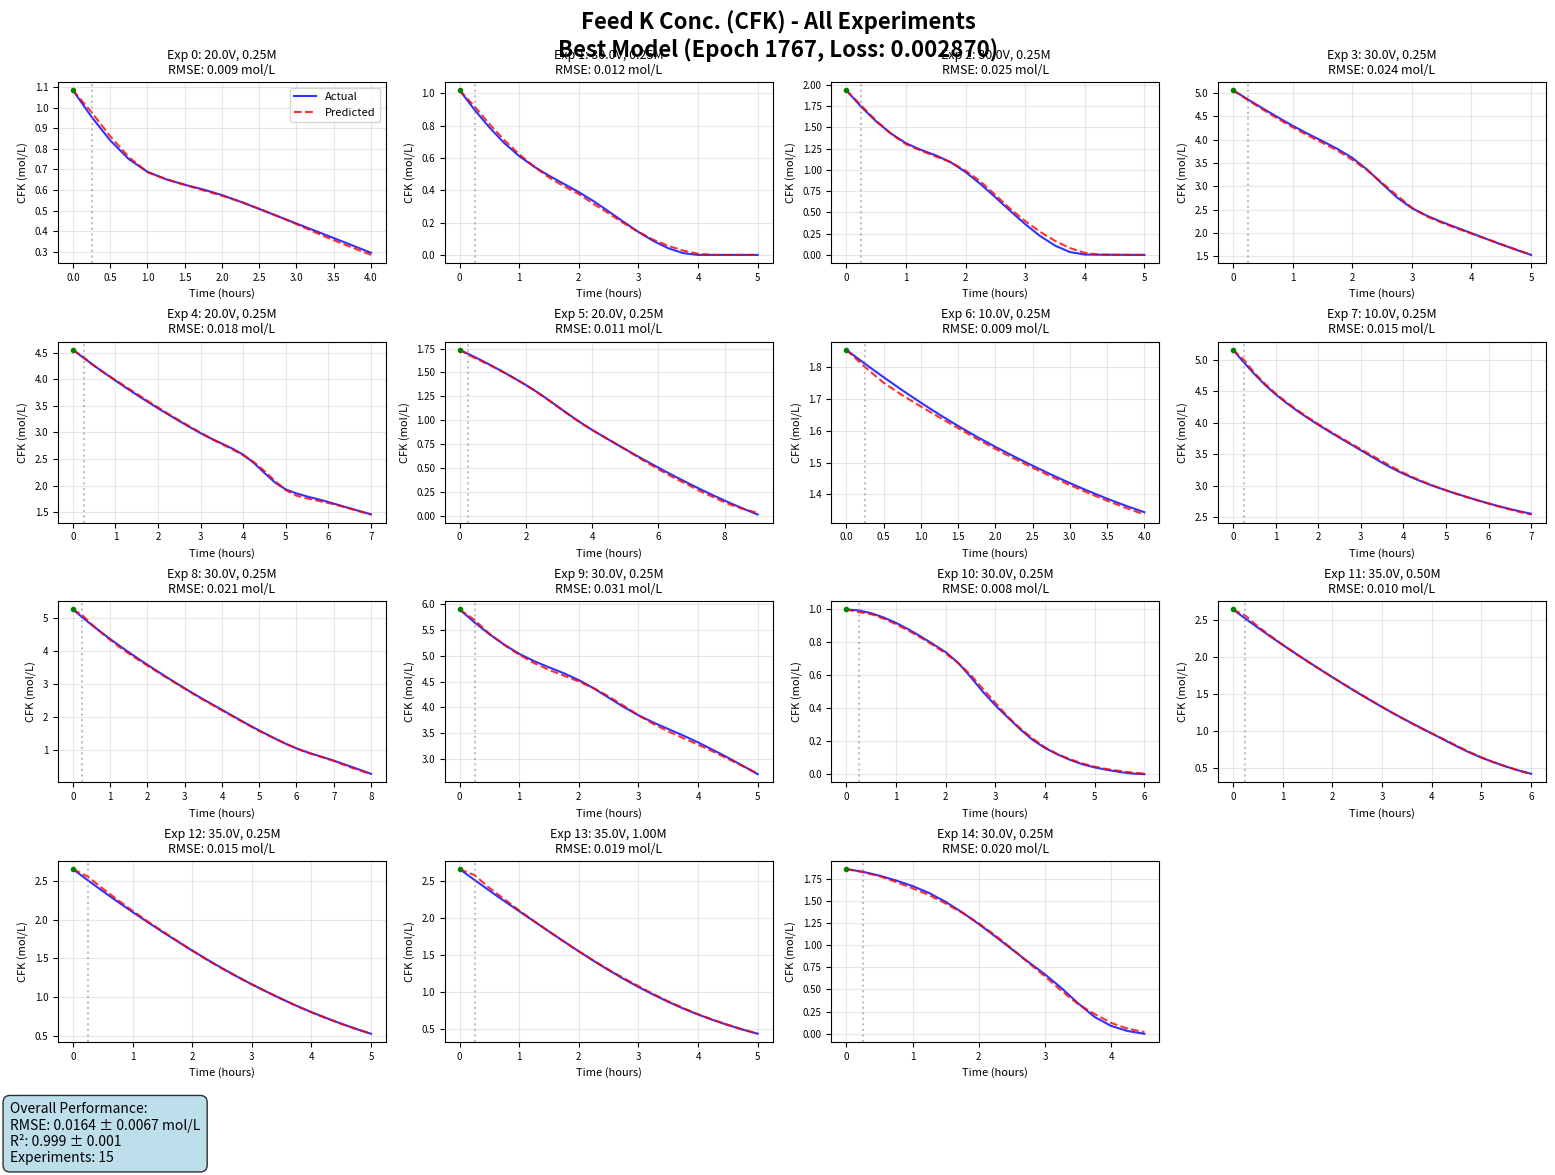

‚úÖ CFK ÏôÑÎ£å: ÌèâÍ∑† RMSE = 0.0164 mol/L, ÌèâÍ∑† R¬≤ = 0.999
üé® Feature 7/8: CBK (Base K Conc.) ÏÉùÏÑ± Ï§ë...


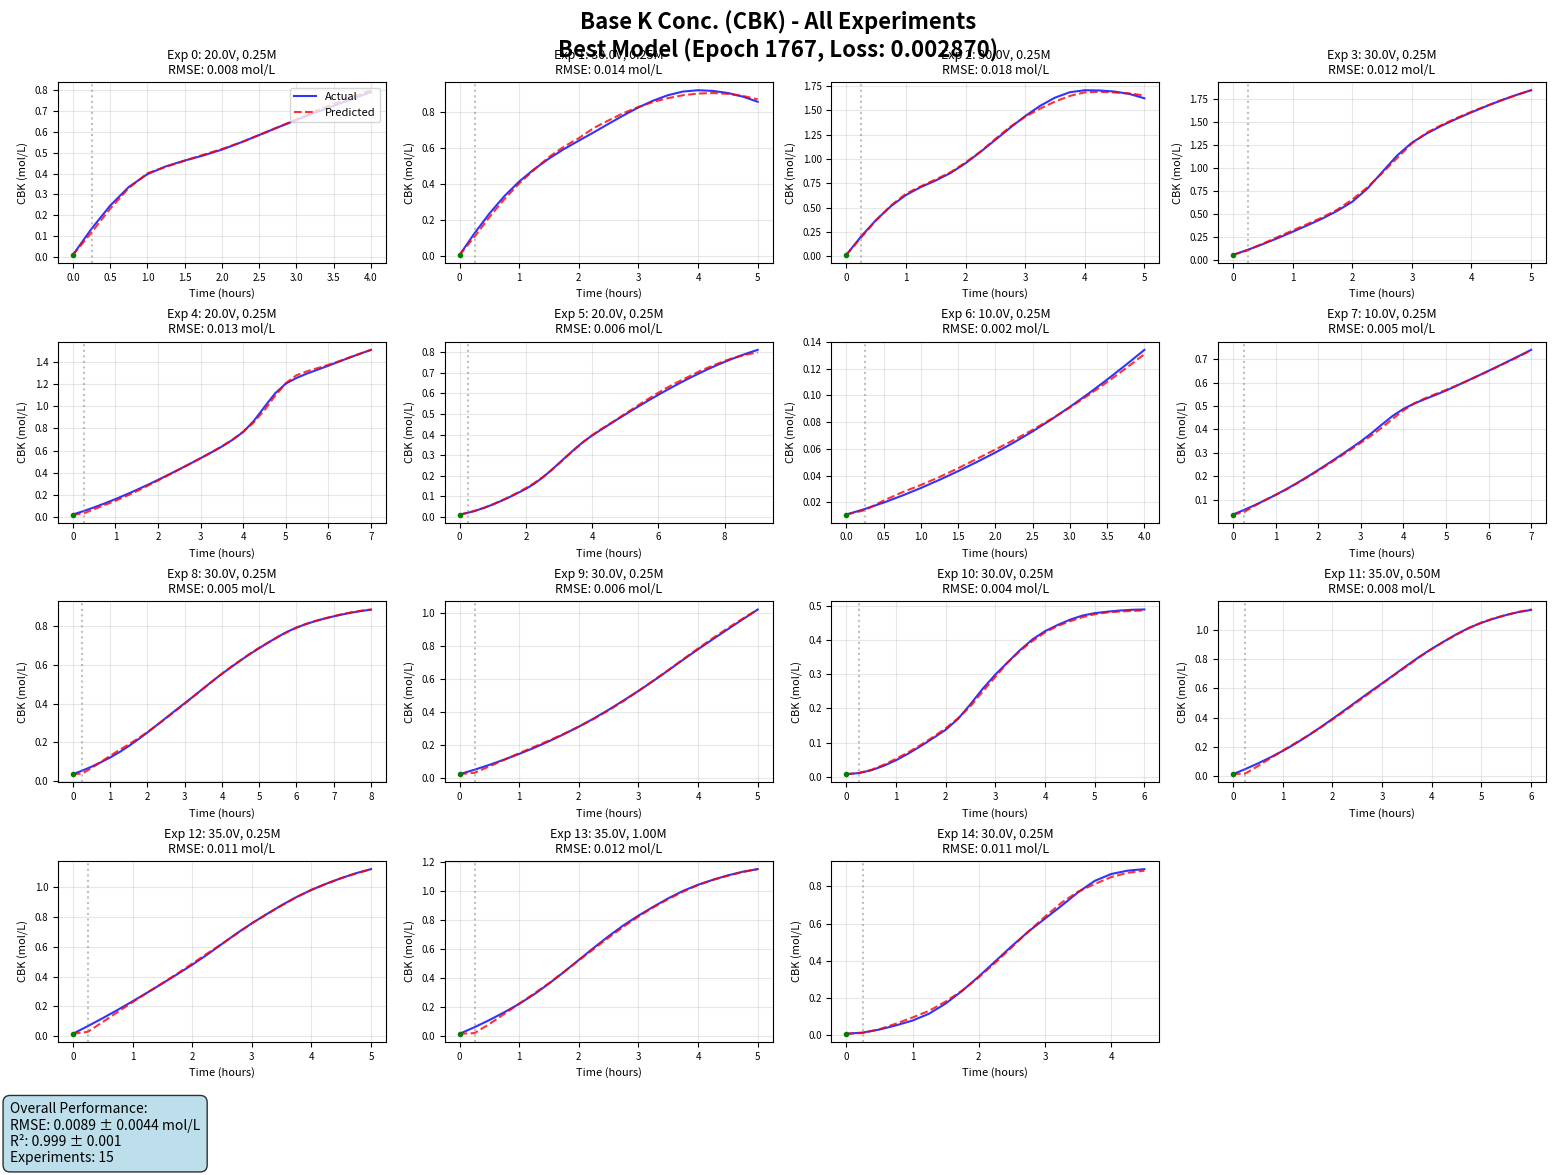

‚úÖ CBK ÏôÑÎ£å: ÌèâÍ∑† RMSE = 0.0089 mol/L, ÌèâÍ∑† R¬≤ = 0.999
üé® Feature 8/8: I (Current) ÏÉùÏÑ± Ï§ë...


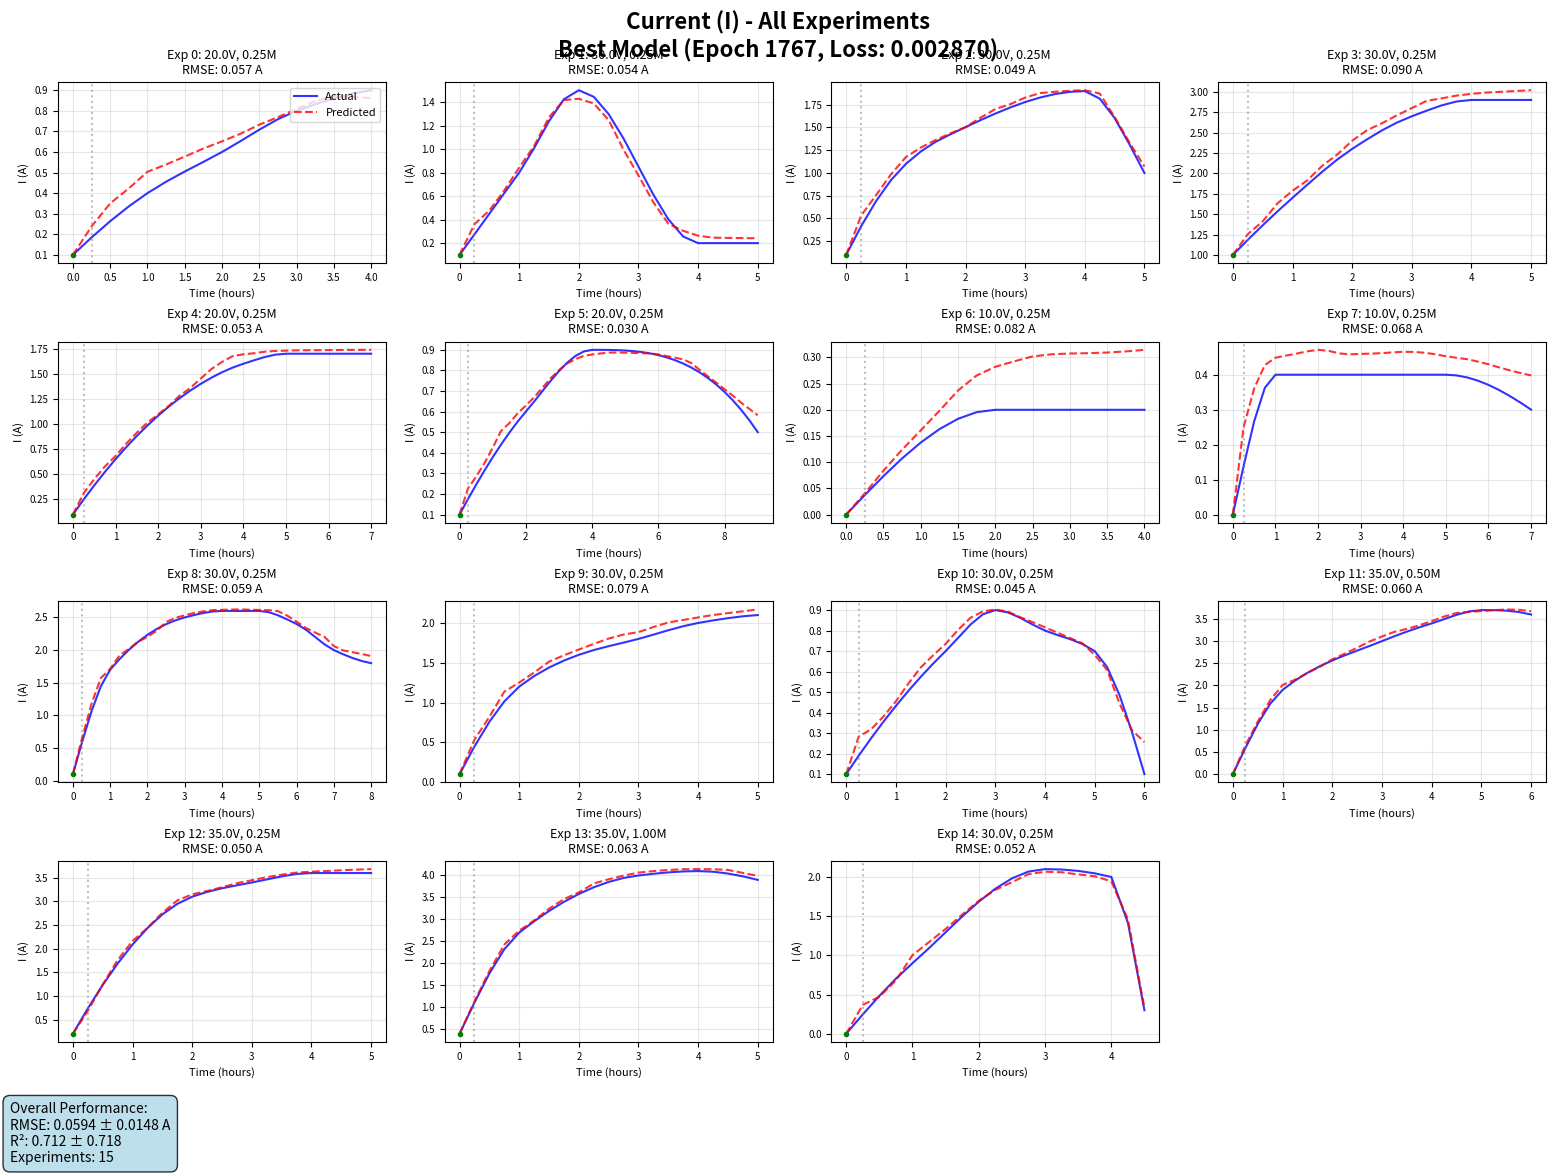

‚úÖ I ÏôÑÎ£å: ÌèâÍ∑† RMSE = 0.0594 A, ÌèâÍ∑† R¬≤ = 0.712

COMPREHENSIVE EVALUATION SUMMARY - ALL EXPERIMENTS
VF    : RMSE=0.0051¬±0.0016 L, MAE=0.0040¬±0.0012 L, R¬≤=0.991¬±0.016
VA    : RMSE=0.0036¬±0.0014 L, MAE=0.0029¬±0.0011 L, R¬≤=0.974¬±0.064
VB    : RMSE=0.0047¬±0.0024 L, MAE=0.0037¬±0.0018 L, R¬≤=0.983¬±0.018
CFLA  : RMSE=0.0116¬±0.0063 mol/L, MAE=0.0090¬±0.0044 mol/L, R¬≤=0.996¬±0.005
CALA  : RMSE=0.0078¬±0.0037 mol/L, MAE=0.0062¬±0.0028 mol/L, R¬≤=0.995¬±0.008
CFK   : RMSE=0.0164¬±0.0067 mol/L, MAE=0.0125¬±0.0058 mol/L, R¬≤=0.999¬±0.001
CBK   : RMSE=0.0089¬±0.0044 mol/L, MAE=0.0066¬±0.0036 mol/L, R¬≤=0.999¬±0.001
I     : RMSE=0.0594¬±0.0148 A, MAE=0.0524¬±0.0166 A, R¬≤=0.712¬±0.718
--------------------------------------------------------------------------------
üìä Total experiments analyzed: 15
üèÜ Best model used: Epoch 1767, Loss: 0.002870
üéâ Comprehensive evaluation ÏôÑÎ£å! 8Í∞úÏùò featureÎ≥Ñ ÌîåÎ°ØÏù¥ Î™®Îì† Ïã§Ìóò Îç∞Ïù¥ÌÑ∞Î•º Ìè¨Ìï®ÌïòÏó¨ ÏÉùÏÑ±ÎêòÏóàÏäµÎãàÎã§.


In [36]:
# Ï†ÑÏ≤¥ Ïã§Ìóò Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú Ï¢ÖÌï©Ï†ÅÏù∏ ÏãúÍ∞ÅÌôî - 8Í∞ú featureÎ≥Ñ Í∞úÎ≥Ñ ÌîåÎ°Ø (ÏàòÏ†ïÎê®)
# Í∞Å ÌîåÎ°ØÏùÄ Î™®Îì† Ïã§ÌóòÏùÑ ÏÑúÎ∏åÌîåÎ°ØÏúºÎ°ú ÌëúÏãú

def denormalize_data(normalized_data, feature_name):
    """Ï†ïÍ∑úÌôîÎêú Îç∞Ïù¥ÌÑ∞Î•º ÏõêÎûò Îã®ÏúÑÎ°ú Î≥µÏõê"""
    if feature_name in range_mm:
        min_val = range_mm[feature_name]['min']
        max_val = range_mm[feature_name]['max']
        return normalized_data * (max_val - min_val) + min_val
    return normalized_data

print("üöÄ Ï†ÑÏ≤¥ Ïã§Ìóò Îç∞Ïù¥ÌÑ∞ comprehensive evaluation ÏãúÏûë...")

# Device Î∞è Î™®Îç∏ ÏÑ§Ï†ï
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
evaluation_model = best_model if best_model is not None else model

# feature Ï†ïÎ≥¥ Ïû¨Ï†ïÏùò
feature_names = ['VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
feature_indices = [2, 3, 4, 5, 6, 7, 8, 9]
feature_units = ['L', 'L', 'L', 'mol/L', 'mol/L', 'mol/L', 'mol/L', 'A']
feature_titles = ['Feed Volume', 'Acid Volume', 'Base Volume', 'Feed LA Conc.', 'Acid LA Conc.', 'Feed K Conc.', 'Base K Conc.', 'Current']

# Ï†ÑÏ≤¥ Ïã§Ìóò Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
all_experiment_results = {}
available_exp_nums = sorted(ndf['exp'].unique())
total_experiments = len(available_exp_nums)

print(f"üìã Ï†ÑÏ≤¥ {total_experiments}Í∞ú Ïã§Ìóò Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Ï§ë...")
print(f"üîß Îç∞Ïù¥ÌÑ∞Î°úÎçî Î∞∞Ïπò ÌÅ¨Í∏∞: {dataloader.batch_size}")
print(f"üîß Ï¥ù Î∞∞Ïπò Í∞úÏàò: {len(dataloader)}")

evaluation_model.eval()
with torch.no_grad():
    experiment_counter = 0
    
    for batch_idx, (input_seq, seq_lengths) in enumerate(dataloader):
        try:
            batch_size = input_seq.size(0)
            print(f"üì¶ Î∞∞Ïπò {batch_idx}: {batch_size}Í∞ú Ïã§Ìóò Ï≤òÎ¶¨ Ï§ë...")
            
            input_seq = input_seq.to(device)
            seq_lengths = seq_lengths.to(device)
            
            # Teacher forcing Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
            inputs, targets, target_seq_lengths = tf_data(input_seq, seq_lengths)
            
            # Î™®Îç∏ ÏòàÏ∏°
            predictions = evaluation_model(inputs, target_seq_lengths)
            
            # CPUÎ°ú Ïù¥Îèô
            predictions_cpu = predictions.cpu().numpy()
            targets_cpu = targets.cpu().numpy()
            input_seq_cpu = input_seq.cpu().numpy()
            
            # Î∞∞Ïπò ÎÇ¥ Î™®Îì† ÏÉòÌîå Ï≤òÎ¶¨
            for sample_idx in range(batch_size):
                if experiment_counter >= total_experiments:
                    break
                    
                # ÌòÑÏû¨ Ïã§Ìóò Î≤àÌò∏
                actual_exp_num = available_exp_nums[experiment_counter]
                
                # ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
                pred_sample = predictions_cpu[sample_idx]
                actual_sample = targets_cpu[sample_idx]
                initial_sample = input_seq_cpu[sample_idx]
                seq_len = target_seq_lengths[sample_idx].item()
                full_seq_len = seq_lengths[sample_idx].item()
                
                # Ïã§Ï†ú ÏãúÌÄÄÏä§ Í∏∏Ïù¥ÎßåÌÅºÎßå ÏÇ¨Ïö©
                pred_sample = pred_sample[:seq_len]
                actual_sample = actual_sample[:seq_len]
                initial_sample = initial_sample[:full_seq_len]
                
                # ÏãúÍ∞Ñ Ï∂ï ÏÉùÏÑ±
                time_points = np.arange(full_seq_len) * 0.25
                
                # ÏòàÏ∏°Í∞íÏùÑ Ï¥àÍ∏∞Í∞íÍ≥º Ïó∞Í≤∞
                prediction_full = np.zeros((full_seq_len, 10))
                prediction_full[0] = initial_sample[0]
                prediction_full[1:seq_len+1] = pred_sample
                
                # Ïã§Ìóò Ï°∞Í±¥ Ï†ïÎ≥¥
                voltage = denormalize_data(initial_sample[0, 0], 'V')
                electrolyte = denormalize_data(initial_sample[0, 1], 'E')
                
                # Í≤∞Í≥º Ï†ÄÏû•
                all_experiment_results[actual_exp_num] = {
                    'time_points': time_points,
                    'actual_data': initial_sample,
                    'predicted_data': prediction_full,
                    'seq_len': seq_len,
                    'full_seq_len': full_seq_len,
                    'voltage': voltage,
                    'electrolyte': electrolyte,
                    'actual_sample': actual_sample,
                    'pred_sample': pred_sample
                }
                
                print(f"‚úÖ Ïã§Ìóò {actual_exp_num}: {full_seq_len*0.25:.1f}h, {voltage:.1f}V, {electrolyte:.3f}M")
                experiment_counter += 1
            
        except Exception as e:
            print(f"‚ùå Î∞∞Ïπò {batch_idx} Ïò§Î•ò: {str(e)}")
            import traceback
            traceback.print_exc()
            continue

print(f"üìä Ï¥ù {len(all_experiment_results)}Í∞ú Ïã§Ìóò Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å!")

# ÏÑúÎ∏åÌîåÎ°Ø Î∞∞Ïπò Í≥ÑÏÇ∞
import math
sqrt_exp = math.ceil(math.sqrt(total_experiments))
if sqrt_exp * (sqrt_exp - 1) >= total_experiments:
    grid_rows, grid_cols = sqrt_exp - 1, sqrt_exp
else:
    grid_rows, grid_cols = sqrt_exp, sqrt_exp

print(f"üìê Í∞Å featureÎãπ {grid_rows}x{grid_cols} ÏÑúÎ∏åÌîåÎ°Ø Í∑∏Î¶¨Îìú ÏÇ¨Ïö©")

# 8Í∞ú featureÎ≥ÑÎ°ú Í∞úÎ≥Ñ figure ÏÉùÏÑ±
for feature_idx, (feature_name, feature_index, unit, title) in enumerate(zip(feature_names, feature_indices, feature_units, feature_titles)):
    print(f"üé® Feature {feature_idx+1}/8: {feature_name} ({title}) ÏÉùÏÑ± Ï§ë...")
    
    # ÏÉà figure ÏÉùÏÑ±
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(4*grid_cols, 3*grid_rows))
    if best_model is not None:
        suptitle = f'{title} ({feature_name}) - All Experiments\nBest Model (Epoch {best_epoch}, Loss: {best_train_loss:.6f})'
    else:
        suptitle = f'{title} ({feature_name}) - All Experiments\nCurrent Model'
    fig.suptitle(suptitle, fontsize=16, fontweight='bold')
    
    # axes Ï≤òÎ¶¨ (1Ï∞®ÏõêÏúºÎ°ú Î≥ÄÌôò)
    if grid_rows * grid_cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    
    # ÏÑ±Îä• ÏßÄÌëú ÏàòÏßë
    rmse_values = []
    r2_values = []
    
    # Í∞Å Ïã§ÌóòÎ≥Ñ subplot
    for plot_idx, exp_num in enumerate(sorted(all_experiment_results.keys())):
        if plot_idx >= len(axes):
            break
            
        ax = axes[plot_idx]
        exp_data = all_experiment_results[exp_num]
        
        # Îç∞Ïù¥ÌÑ∞ denormalize
        actual_denorm = denormalize_data(exp_data['actual_data'][:, feature_index], feature_name)
        pred_denorm = denormalize_data(exp_data['predicted_data'][:exp_data['seq_len']+1, feature_index], feature_name)
        
        # ÌîåÎ°Ø ÏÉùÏÑ±
        ax.plot(exp_data['time_points'], actual_denorm, 'b-', linewidth=1.5, label='Actual', alpha=0.8)
        ax.plot(exp_data['time_points'][:exp_data['seq_len']+1], pred_denorm, 'r--', linewidth=1.5, label='Predicted', alpha=0.8)
        
        # ÏãúÏûëÏ†ê ÌëúÏãú
        ax.plot(exp_data['time_points'][0], actual_denorm[0], 'go', markersize=3)
        ax.axvline(x=exp_data['time_points'][1], color='gray', linestyle=':', alpha=0.5)
        
        # ÏÑ±Îä• ÏßÄÌëú Í≥ÑÏÇ∞
        actual_pred_denorm = denormalize_data(exp_data['actual_sample'][:, feature_index], feature_name)
        pred_pred_denorm = denormalize_data(exp_data['pred_sample'][:, feature_index], feature_name)
        
        rmse = np.sqrt(np.mean((actual_pred_denorm - pred_pred_denorm)**2))
        if np.sum((actual_pred_denorm - np.mean(actual_pred_denorm))**2) > 0:
            r2 = 1 - (np.sum((actual_pred_denorm - pred_pred_denorm)**2) / np.sum((actual_pred_denorm - np.mean(actual_pred_denorm))**2))
        else:
            r2 = 0.0
            
        rmse_values.append(rmse)
        r2_values.append(r2)
        
        # ÏÑúÎ∏åÌîåÎ°Ø ÏÑ§Ï†ï
        condition_text = f'{exp_data["voltage"]:.1f}V, {exp_data["electrolyte"]:.2f}M'
        ax.set_title(f'Exp {exp_num}: {condition_text}\nRMSE: {rmse:.3f} {unit}', fontsize=9)
        ax.set_xlabel('Time (hours)', fontsize=8)
        ax.set_ylabel(f'{feature_name} ({unit})', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=7)
        
        # Ï≤´ Î≤àÏß∏ subplotÏóêÎßå Î≤îÎ°Ä Ï∂îÍ∞Ä
        if plot_idx == 0:
            ax.legend(fontsize=8, loc='upper right')
    
    # Îπà subplot Ïà®Í∏∞Í∏∞
    for plot_idx in range(len(all_experiment_results), len(axes)):
        axes[plot_idx].set_visible(False)
    
    # Ï†ÑÏ≤¥ ÏÑ±Îä• ÏöîÏïΩ
    avg_rmse = np.mean(rmse_values)
    std_rmse = np.std(rmse_values)
    avg_r2 = np.mean(r2_values)
    std_r2 = np.std(r2_values)
    
    # ÏÑ±Îä• ÏöîÏïΩ ÌÖçÏä§Ìä∏ Î∞ïÏä§
    summary_text = f'Overall Performance:\nRMSE: {avg_rmse:.4f} ¬± {std_rmse:.4f} {unit}\nR¬≤: {avg_r2:.3f} ¬± {std_r2:.3f}\nExperiments: {len(rmse_values)}'
    fig.text(0.02, 0.02, summary_text, fontsize=10, 
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.12, left=0.05, right=0.98)
    plt.show()
    
    print(f"‚úÖ {feature_name} ÏôÑÎ£å: ÌèâÍ∑† RMSE = {avg_rmse:.4f} {unit}, ÌèâÍ∑† R¬≤ = {avg_r2:.3f}")

# Ï†ÑÏ≤¥ ÏöîÏïΩ Ï∂úÎ†•
print("\n" + "="*80)
print("COMPREHENSIVE EVALUATION SUMMARY - ALL EXPERIMENTS")
print("="*80)

for feature_idx, (feature_name, feature_index, unit) in enumerate(zip(feature_names, feature_indices, feature_units)):
    # Í∞Å featureÎ≥Ñ Ï†ÑÏ≤¥ ÏÑ±Îä• ÌÜµÍ≥Ñ
    all_rmse = []
    all_mae = []
    all_r2 = []
    
    for exp_num in sorted(all_experiment_results.keys()):
        exp_data = all_experiment_results[exp_num]
        
        actual_pred_denorm = denormalize_data(exp_data['actual_sample'][:, feature_index], feature_name)
        pred_pred_denorm = denormalize_data(exp_data['pred_sample'][:, feature_index], feature_name)
        
        rmse = np.sqrt(np.mean((actual_pred_denorm - pred_pred_denorm)**2))
        mae = np.mean(np.abs(actual_pred_denorm - pred_pred_denorm))
        
        if np.sum((actual_pred_denorm - np.mean(actual_pred_denorm))**2) > 0:
            r2 = 1 - (np.sum((actual_pred_denorm - pred_pred_denorm)**2) / np.sum((actual_pred_denorm - np.mean(actual_pred_denorm))**2))
        else:
            r2 = 0.0
        
        all_rmse.append(rmse)
        all_mae.append(mae)
        all_r2.append(r2)
    
    print(f"{feature_name:6s}: RMSE={np.mean(all_rmse):.4f}¬±{np.std(all_rmse):.4f} {unit}, "
          f"MAE={np.mean(all_mae):.4f}¬±{np.std(all_mae):.4f} {unit}, "
          f"R¬≤={np.mean(all_r2):.3f}¬±{np.std(all_r2):.3f}")

print("-"*80)
print(f"üìä Total experiments analyzed: {len(all_experiment_results)}")
if best_model is not None:
    print(f"üèÜ Best model used: Epoch {best_epoch}, Loss: {best_train_loss:.6f}")
else:
    print("üìã Current model used")
print("="*80)

print("üéâ Comprehensive evaluation ÏôÑÎ£å! 8Í∞úÏùò featureÎ≥Ñ ÌîåÎ°ØÏù¥ Î™®Îì† Ïã§Ìóò Îç∞Ïù¥ÌÑ∞Î•º Ìè¨Ìï®ÌïòÏó¨ ÏÉùÏÑ±ÎêòÏóàÏäµÎãàÎã§.")